## Stock Price Prediction - Transformers

### 1. Importing Libraries

In [ ]:
pip install hyperopt

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Input, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### 2. Data Collection and Preprocessing

In [2]:
# Download AAPL stock data from 2015 to 2019
aapl_data = yf.download('AAPL', start='2015-01-01', end='2019-12-31', interval='1d')

ticker = 'AAPL'
start_date = '2015-01-02'
end_date = '2019-12-31'

full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
apple_stock_data_full = aapl_data.reindex(full_date_range)

# Interpolate the missing data using linear method
apple_stock_data_interpolated = apple_stock_data_full.interpolate(method='linear')
aapl_data = apple_stock_data_interpolated.dropna()

# Create additional features
aapl_data['width'] = aapl_data['High'] - aapl_data['Low']  # Daily range (High - Low)
aapl_data['diff'] = aapl_data['Adj Close'].diff()  # Price difference
aapl_data['pct_change'] = aapl_data['Adj Close'].pct_change()  # Percentage price change

# Relative Strength Index (RSI)
window_length = 14
delta = aapl_data['Adj Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
aapl_data['RSI'] = 100 - (100 / (1 + rs))

# Rate of Change (ROC)
aapl_data['ROC'] = aapl_data['Adj Close'].pct_change(periods=window_length) * 100

# Drop NaN values created by rolling calculations
aapl_data.dropna(inplace=True)

# Display the first few rows to check the created features
aapl_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,width,diff,pct_change,RSI,ROC
2015-01-16,26.757500,26.895000,26.299999,26.497499,23.629341,314053200.0,0.595001,-0.185041,-0.007770,40.059501,-3.054987
2015-01-17,26.808125,26.981875,26.381249,26.668125,23.781497,285439800.0,0.600626,0.152156,0.006439,45.044783,-1.505816
2015-01-18,26.858749,27.068750,26.462500,26.838750,23.933653,256826400.0,0.606251,0.152156,0.006398,50.243052,0.073007
2015-01-19,26.909374,27.155625,26.543750,27.009375,24.085809,228213000.0,0.611876,0.152156,0.006357,55.668253,1.682341
2015-01-20,26.959999,27.242500,26.625000,27.180000,24.237965,199599600.0,0.617500,0.152156,0.006317,57.481714,2.315071
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.316277,146266000.0,1.462502,-0.026711,-0.000380,92.170269,5.324378
2019-12-28,72.641665,73.385834,71.788333,72.593330,70.455388,145548800.0,1.597501,0.139112,0.001978,91.693659,4.933993
2019-12-29,72.503332,73.279167,71.546666,72.736664,70.594500,144831600.0,1.732501,0.139112,0.001974,91.155264,4.548013
2019-12-30,72.364998,73.172501,71.305000,72.879997,70.733612,144114400.0,1.867500,0.139112,0.001971,90.542237,4.166364


### 3. Data Visualization

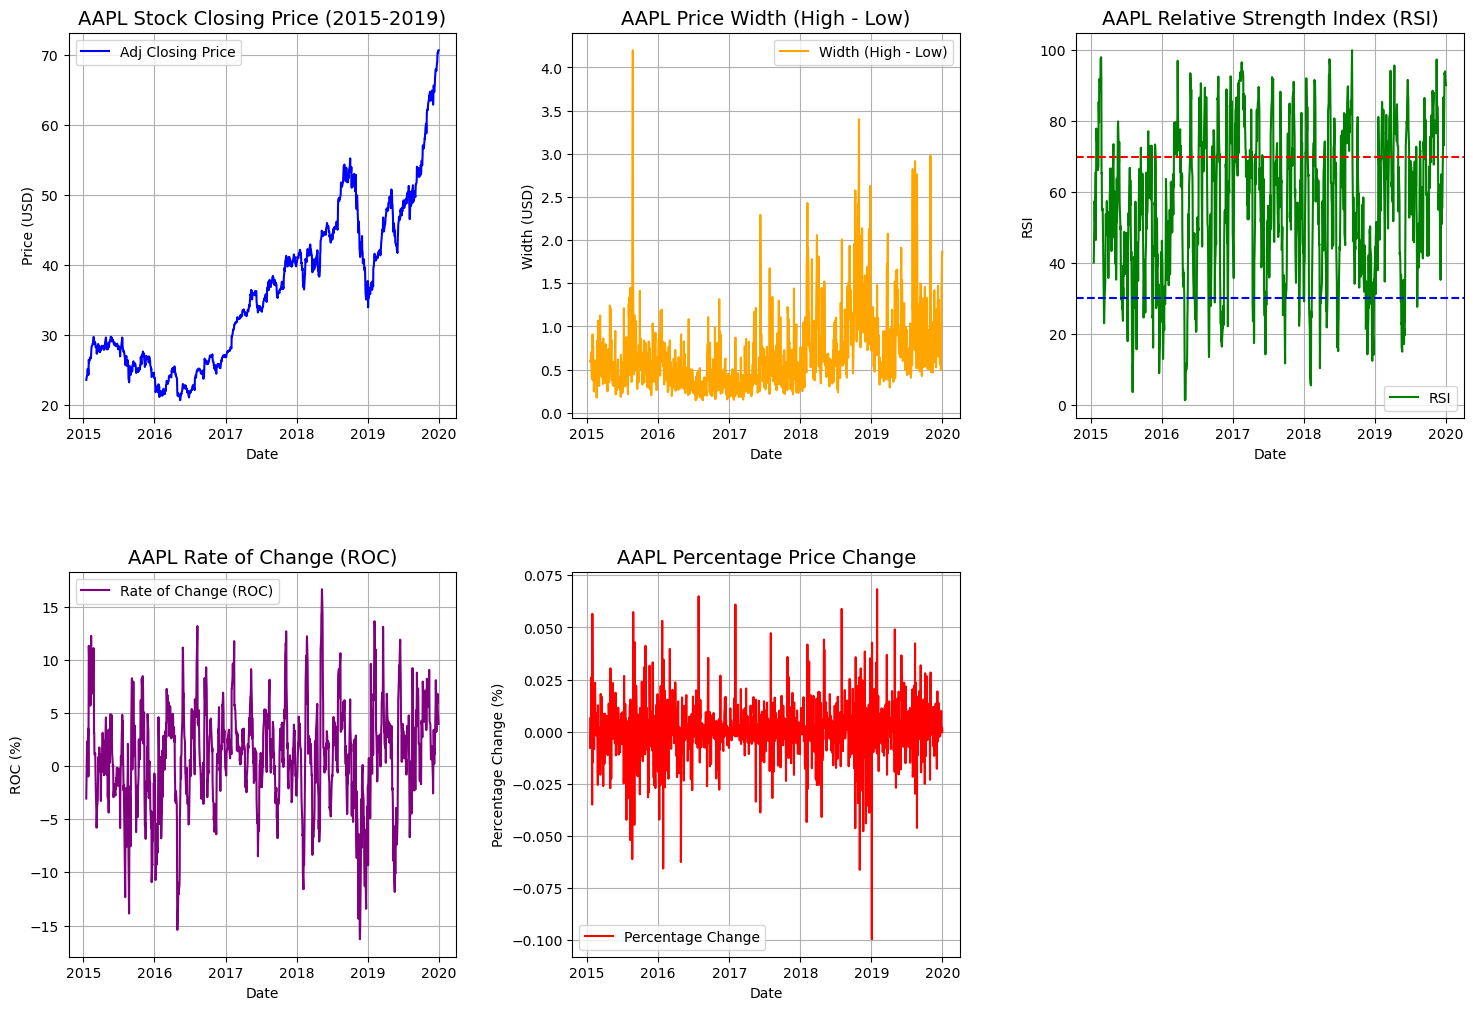

In [3]:
# Create a figure and a grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Adjust space between plots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot 1: Closing Price
axes[0, 0].plot(aapl_data.index, aapl_data['Adj Close'], label='Adj Closing Price', color='blue')
axes[0, 0].set_title('AAPL Stock Closing Price (2015-2019)', fontsize=14)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Plot 2: Daily Width (High - Low)
axes[0, 1].plot(aapl_data.index, aapl_data['width'], label='Width (High - Low)', color='orange')
axes[0, 1].set_title('AAPL Price Width (High - Low)', fontsize=14)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Width (USD)')
axes[0, 1].grid(True)
axes[0, 1].legend()

# Plot 3: Relative Strength Index (RSI)
axes[0, 2].plot(aapl_data.index, aapl_data['RSI'], label='RSI', color='green')
axes[0, 2].axhline(70, color='red', linestyle='--')  # Overbought threshold
axes[0, 2].axhline(30, color='blue', linestyle='--')  # Oversold threshold
axes[0, 2].set_title('AAPL Relative Strength Index (RSI)', fontsize=14)
axes[0, 2].set_xlabel('Date')
axes[0, 2].set_ylabel('RSI')
axes[0, 2].grid(True)
axes[0, 2].legend()

# Plot 4: Rate of Change (ROC)
axes[1, 0].plot(aapl_data.index, aapl_data['ROC'], label='Rate of Change (ROC)', color='purple')
axes[1, 0].set_title('AAPL Rate of Change (ROC)', fontsize=14)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('ROC (%)')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Plot 5: Percentage Change
axes[1, 1].plot(aapl_data.index, aapl_data['pct_change'], label='Percentage Change', color='red')
axes[1, 1].set_title('AAPL Percentage Price Change', fontsize=14)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Percentage Change (%)')
axes[1, 1].grid(True)
axes[1, 1].legend()

# Hide the empty subplot (axes[1, 2]) in the second row
axes[1, 2].axis('off')

# Show the plot
plt.show()


### 4. Feature selection, Data Split 75:15:15 and Normalization

In [4]:
# Select features to be included in the model
features = ['Adj Close', 'width', 'RSI', 'ROC', 'Volume', 'diff', 'pct_change']

# Define split percentages (e.g., 75% training, 15% validation, 15% test)
train_size = 0.7
val_size = 0.15

# Calculate indices for splitting
train_index = int(len(aapl_data) * train_size)
val_index = int(len(aapl_data) * (train_size + val_size))

# Split the data
train_data = aapl_data[features].iloc[:train_index]
val_data = aapl_data[features].iloc[train_index:val_index]
test_data = aapl_data[features].iloc[val_index:]

In [5]:
# Initialize the MinMaxScaler and fit only on the training data
scaler = MinMaxScaler(feature_range=(0, 1))

train_data_scaled = scaler.fit_transform(train_data)

# Transform the validation and test data using the same scaler
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

# Convert scaled data back into DataFrames for easier handling
train_data_scaled_df = pd.DataFrame(train_data_scaled, columns=features, index=train_data.index)
val_data_scaled_df = pd.DataFrame(val_data_scaled, columns=features, index=val_data.index)
test_data_scaled_df = pd.DataFrame(test_data_scaled, columns=features, index=test_data.index)

### 5. Create sequences of 30 for Transformer Input

In [6]:
# Create sequences for Transformer input
def create_sequences_multifeature(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])  # Predicting the next 'Adj Close' price
    return np.array(X), np.array(y)

sequence_length = 30  # Using the last 30 days to predict the next day's price

# Create sequences for training, validation, and test sets
X_train, y_train = create_sequences_multifeature(train_data_scaled, sequence_length)
X_val, y_val = create_sequences_multifeature(val_data_scaled, sequence_length)
X_test, y_test = create_sequences_multifeature(test_data_scaled, sequence_length)

# Display shapes to confirm
print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation data shape: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training data shape: X_train: (1237, 30, 7), y_train: (1237,)
Validation data shape: X_val: (242, 30, 7), y_val: (242,)
Test data shape: X_test: (242, 30, 7), y_test: (242,)


### 6. Transformer Model

In [7]:
# Define function for positional encoding
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # Apply sin to even indices and cos to odd indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

In [8]:
#  Define the Transformer Model
def transformer_encoder(inputs, num_heads, dff, d_model, dropout_rate):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
    attention_output = attention(inputs, inputs)
    
    # Add & Norm
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    
    # Feed-forward Network
    ff_output = Dense(dff, activation='relu')(attention_output)
    ff_output = Dense(d_model)(ff_output)
    
    # Add & Norm
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)
    
    return ff_output

In [9]:
# Transformer Model to include a Dense layer to match input features with d_model
def build_transformer_model(sequence_length, num_features, d_model, num_heads, dff, dropout_rate):
    inputs = Input(shape=(sequence_length, num_features))
    
    # Project the input features (num_features) into the 
    # same dimension as the positional encoding (d_model)
    input_projection = Dense(d_model)(inputs)
    
    # Positional Encoding
    pos_encoding = positional_encoding(sequence_length, d_model)
    inputs_pos_encoded = input_projection + pos_encoding
    
    # Encoder layers
    encoder_output = transformer_encoder(inputs_pos_encoded, num_heads, dff, d_model, dropout_rate)
    
    # Output layer (regression task)
    outputs = Dense(1)(encoder_output[:, -1, :])  # Use the last time step for prediction
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

#### Grid search to find best hyperparameters for training transformer model

In [10]:
import itertools
import pandas as pd

# Define the hyperparameter values to search over
d_model_values = [64, 128, 256]   # Model dimensions
num_heads_values = [2, 4, 8]      # Number of attention heads
dff_values = [128, 256, 512]      # Feed-forward network dimensions
batch_size_values = [32, 64]      # Batch sizes
num_features = len(features)

# Keep dropout fixed
dropout_rate = 0.2

# Dictionary to store results
results = []

# Loop over all combinations of hyperparameters
for d_model, num_heads, dff, batch_size in itertools.product(d_model_values, num_heads_values, dff_values, batch_size_values):
    
    print(f"Training with d_model={d_model}, num_heads={num_heads}, dff={dff}, batch_size={batch_size}")
    
    # Build the model with current hyperparameters
    transformer_model = build_transformer_model(sequence_length, num_features, d_model, num_heads, dff, dropout_rate)
    
    # Compile the model
    transformer_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    history = transformer_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,  # Train for fewer epochs to speed up the search
        batch_size=batch_size,
        verbose=0  # Suppress training output for readability
    )
    
    # Get the average training and validation losses from the last few epochs
    avg_train_loss = np.mean(history.history['loss'][-5:])
    avg_val_loss = np.mean(history.history['val_loss'][-5:])
    print(f"Validation loss : {avg_val_loss}")
    print("------------------------------------------------------------\n")
    
    # Store the results in the list
    results.append({
        'd_model': d_model,
        'num_heads': num_heads,
        'dff': dff,
        'batch_size': batch_size,
        'avg_train_loss': avg_train_loss,
        'avg_val_loss': avg_val_loss,
        'gap': abs(avg_train_loss - avg_val_loss)  # The difference between training and validation losses
    })

# Convert the results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Sort by validation loss and gap to find the best combination
results_df_sorted = results_df.sort_values(by=['avg_val_loss', 'gap']).reset_index(drop=True)

# Display the sorted results
print(results_df_sorted.head())


Training with d_model=64, num_heads=2, dff=128, batch_size=32
Validation loss : 0.008514276798814535
------------------------------------------------------------

Training with d_model=64, num_heads=2, dff=128, batch_size=64
Validation loss : 0.016106658801436424
------------------------------------------------------------

Training with d_model=64, num_heads=2, dff=256, batch_size=32
Validation loss : 0.013440772332251072
------------------------------------------------------------

Training with d_model=64, num_heads=2, dff=256, batch_size=64
Validation loss : 0.017439812049269678
------------------------------------------------------------

Training with d_model=64, num_heads=2, dff=512, batch_size=32
Validation loss : 0.02529059909284115
------------------------------------------------------------

Training with d_model=64, num_heads=2, dff=512, batch_size=64
Validation loss : 0.012050786800682545
------------------------------------------------------------

Training with d_model=6

In [11]:
results_df_sorted.head()

,d_model,num_heads,dff,batch_size,avg_train_loss,avg_val_loss,gap
0,256,8,128,32,0.000294,0.001613,0.001318
1,128,4,512,32,0.000387,0.001674,0.001287
2,128,8,512,32,0.000313,0.001781,0.001468
3,128,8,128,32,0.000289,0.002313,0.002024
4,128,2,256,64,0.000316,0.002547,0.002231


#### Bayesian optimization to find best hyperparameters for training transformer model

In [14]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Define the actual search space and their corresponding mappings
d_model_values = [64, 128, 256]
num_heads_values = [2, 4, 8]
dff_values = [128, 256, 512]
batch_size_values = [32, 64]
# Keep dropout fixed
dropout_rate = 0.2

# Define the search space using indices
search_space = {
    'd_model': hp.choice('d_model', list(range(len(d_model_values)))),
    'num_heads': hp.choice('num_heads', list(range(len(num_heads_values)))),
    'dff': hp.choice('dff', list(range(len(dff_values)))),
    'batch_size': hp.choice('batch_size', list(range(len(batch_size_values))))
}

# Define the objective function for Hyperopt
def objective(params):
    # Map indices back to actual values
    d_model = d_model_values[params['d_model']]
    num_heads = num_heads_values[params['num_heads']]
    dff = dff_values[params['dff']]
    batch_size = batch_size_values[params['batch_size']]

    # Print the current hyperparameters being tested
    print(f"Testing model with: d_model={d_model}, num_heads={num_heads}, dff={dff}, batch_size={batch_size}")
    
    # Build and compile the model
    transformer_model = build_transformer_model(sequence_length, num_features, d_model, num_heads, dff, dropout_rate)
    transformer_model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = transformer_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,  # Use fewer epochs to speed up the trials
        batch_size=batch_size,
        verbose=0  # Suppress output for faster trials
    )
    
    # Get the validation loss (mean of the last 5 epochs)
    avg_val_loss = np.mean(history.history['val_loss'][-5:])
    
    # Print the validation loss for tracking
    print(f"Validation Loss for current model: {avg_val_loss}")
    print("---------------------------------------------------------")
    
    # Return the validation loss for optimization
    return {'loss': avg_val_loss, 'status': STATUS_OK}


# Run Bayesian optimization using the Tree of Parzen Estimators (TPE) algorithm
trials = Trials()
best = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=20, trials=trials)

# Get all trial results
trial_results = []
for trial in trials.trials:
    trial_results.append({
        'd_model': d_model_values[trial['misc']['vals']['d_model'][0]],  # Map index to actual d_model value
        'num_heads': num_heads_values[trial['misc']['vals']['num_heads'][0]],  # Map index to actual num_heads value
        'dff': dff_values[trial['misc']['vals']['dff'][0]],  # Map index to actual dff value
        'batch_size': batch_size_values[trial['misc']['vals']['batch_size'][0]],  # Map index to actual batch_size value
        'loss': trial['result']['loss']
    })

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(trial_results)


Testing model with: d_model=128, num_heads=4, dff=256, batch_size=32            
Validation Loss for current model: 0.005469844862818718                         
---------------------------------------------------------                       
Testing model with: d_model=128, num_heads=8, dff=512, batch_size=32            
Validation Loss for current model: 0.0052002714946866035                        
---------------------------------------------------------                       
Testing model with: d_model=128, num_heads=2, dff=128, batch_size=32            
Validation Loss for current model: 0.0035883267410099506                        
---------------------------------------------------------                       
Testing model with: d_model=128, num_heads=8, dff=128, batch_size=32            
Validation Loss for current model: 0.004149084212258458                         
---------------------------------------------------------                       
Testing model with: d_model=

In [19]:
# Sort by loss to get the best performing hyperparameters
results_df_sorted1 = results_df.sort_values(by='loss').reset_index(drop=True)

# Display the top 5 hyperparameter combinations
top_b5 = results_df_sorted1.head(5)
print(top_b5)

   d_model  num_heads  dff  batch_size      loss
0      128          2  128          32  0.001993
1      128          8  512          32  0.003556
2      128          2  128          32  0.003588
3      128          8  128          32  0.004149
4       64          8  256          64  0.004667


#### Define model with optimal hyperparameters

In [20]:
# Define model parameters
d_model = 128  # Dimension of the model
num_heads = 2  # Number of attention heads
dff = 128  # Feed-forward network dimension
dropout_rate = 0.2  # Dropout rate
num_features = len(features)  # Number of input features (e.g., 7 in this case)

# Build and compile the model
transformer_model = build_transformer_model(sequence_length, num_features, 
                                            d_model, num_heads, dff, 
                                            dropout_rate)

# Display the model summary
transformer_model.summary()


Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_94      │ (None, 30, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_376 (Dense)   │ (None, 30, 128)   │      1,024 │ input_layer_94[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_282 (Add)       │ (None, 30, 128)   │          0 │ dense_376[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 128)   │    131,968 │ add_282[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_282[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_283 (Add)       │ (None, 30, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_282[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 128)   │        256 │ add_283[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_377 (Dense)   │ (None, 30, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_378 (Dense)   │ (None, 30, 128)   │     16,512 │ dense_377[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_284 (Add)       │ (None, 30, 128)   │          0 │ dense_378[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 128)   │        256 │ add_284[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_94         │ (None, 128)       │          0 │ layer_normalizat… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_379 (Dense)   │ (None, 1)         │        129 │ get_item_94[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 166,657 (651.00 KB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = transformer_model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val), 
                                epochs=100, 
                                batch_size=32, 
                                callbacks=[early_stop])


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8472 - val_loss: 0.1606
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0343 - val_loss: 0.0215
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.8936e-04 - val_loss: 0.0024
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.6757e-04 - val_loss: 0.0020
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.6008e-04 - val_loss: 0.0016
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.9234e-04 - val_loss: 0.0022
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.3589e-04 - val_loss: 0.0017
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.9425e-04 - val_loss: 0.0019
Epoch 12/100
39/39 ━━━━━━━━━

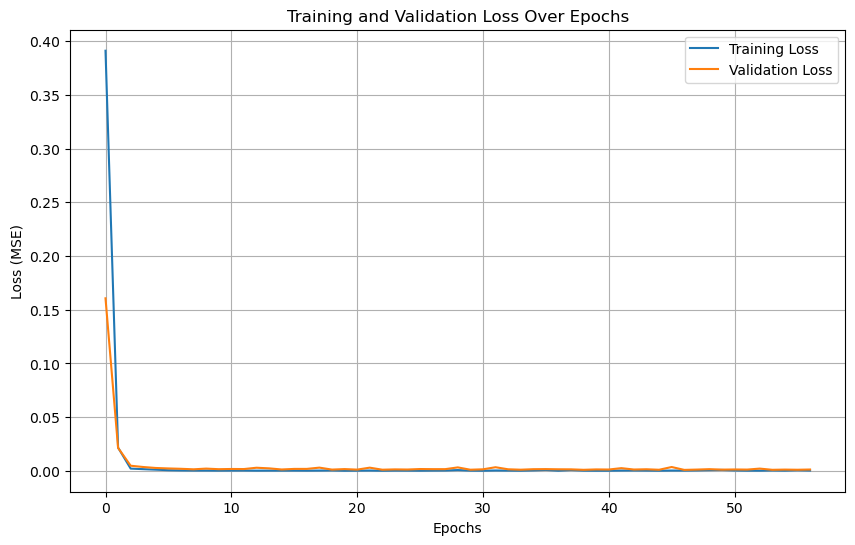

In [22]:
def plot_loss_curve(history):
    # Extract loss values from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the loss curve
plot_loss_curve(history)


### 7. Model Performance Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Mean Squared Error: 0.5089780698067263
R² Score: 0.9914487411202166
MAPE Score: 0.010357844150836


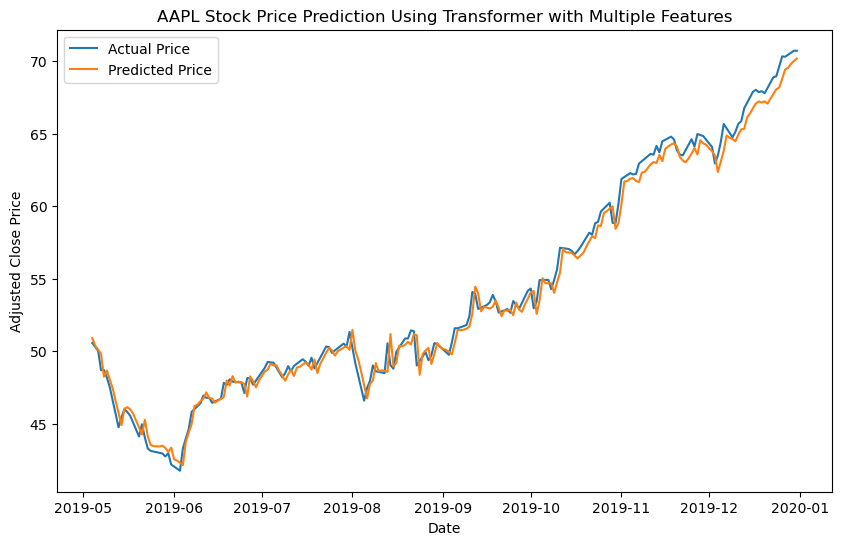

In [23]:
# Make predictions on the test data
predictions = transformer_model.predict(X_test)

# Rescale the predictions and actual values back to original scale
predictions_rescaled = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], len(features)-1))], axis=1))[:,0]
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1))], axis=1))[:,0]

# Calculate Mean Squared Error and R² score
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
print(f'MAPE Score: {mape}')

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(aapl_data.index[val_index+sequence_length:], y_test_rescaled, label='Actual Price')
plt.plot(aapl_data.index[val_index+sequence_length:], predictions_rescaled, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('AAPL Stock Price Prediction Using Transformer with Multiple Features')
plt.legend()
plt.show()


In [24]:
# Save the model weights manually after training
transformer_model.save_weights('final_final_transformer_model128.weights.h5')

In [25]:
# Assuming you have X_train, X_val, X_test, and the trained model available

# Make predictions on training and validation sets
predictions_train = transformer_model.predict(X_train)
predictions_val = transformer_model.predict(X_val)

# Rescale predictions and actual values back to original scale
# Rescale predictions for training and validation sets
predictions_train_rescaled = scaler.inverse_transform(np.concatenate([predictions_train, np.zeros((predictions_train.shape[0], len(features) - 1))], axis=1))[:, 0]
predictions_val_rescaled = scaler.inverse_transform(np.concatenate([predictions_val, np.zeros((predictions_val.shape[0], len(features) - 1))], axis=1))[:, 0]

# Rescale actual values for training and validation sets
y_train_rescaled = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features) - 1))], axis=1))[:, 0]
y_val_rescaled = scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1), np.zeros((y_val.shape[0], len(features) - 1))], axis=1))[:, 0]

# Adjust the indexes by sequence_length (the first 'sequence_length' values are not predicted)
train_index = aapl_data.index[sequence_length:sequence_length+len(y_train_rescaled)]
val_index = aapl_data.index[sequence_length+len(y_train_rescaled):sequence_length+len(y_train_rescaled) + len(y_val_rescaled)]
test_index = aapl_data.index[sequence_length+len(y_train_rescaled) + len(y_val_rescaled):]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [26]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pandas as pd

# Calculate performance metrics for training set
mse_train = mean_squared_error(y_train_rescaled, predictions_train_rescaled)
r2_train = r2_score(y_train_rescaled, predictions_train_rescaled)
mape_train = mean_absolute_percentage_error(y_train_rescaled, predictions_train_rescaled)

# Calculate performance metrics for validation set
mse_val = mean_squared_error(y_val_rescaled, predictions_val_rescaled)
r2_val = r2_score(y_val_rescaled, predictions_val_rescaled)
mape_val = mean_absolute_percentage_error(y_val_rescaled, predictions_val_rescaled)

# Calculate performance metrics for test set
mse_test = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2_test = r2_score(y_test_rescaled, predictions_rescaled)
mape_test = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled)

# Create a DataFrame to store the results
performance_metrics = pd.DataFrame({
    'Metric': ['MSE', 'MAPE', 'R²'],
    'Training Data': [mse_train, mape_train, r2_train],
    'Validation Data': [mse_val, mape_val, r2_val],
    'Test Data': [mse_test, mape_test, r2_test]
})

# Display the DataFrame
print(performance_metrics)


  Metric  Training Data  Validation Data  Test Data
0    MSE       0.116749         0.656560   0.508978
1   MAPE       0.007845         0.012908   0.010358
2     R²       0.997542         0.982176   0.991449


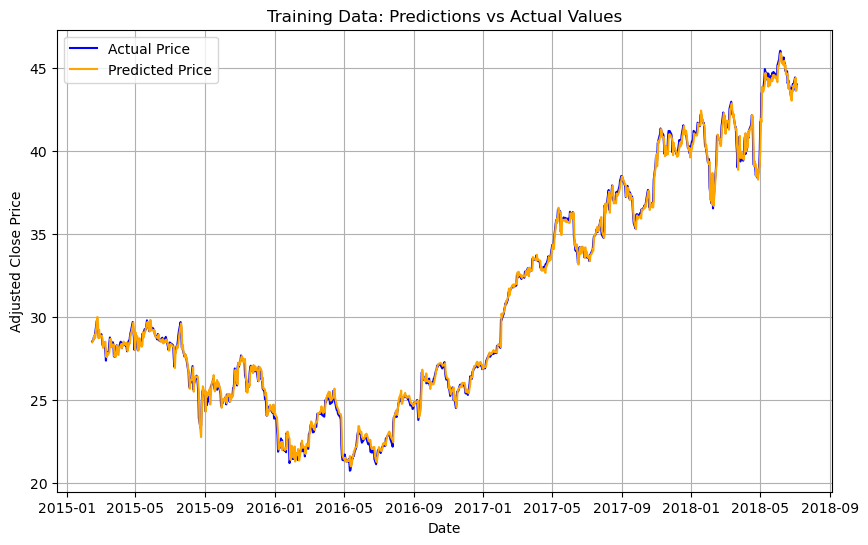

In [27]:
# Plot 1: Training Data: Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(train_index, y_train_rescaled, label='Actual Price', color='blue')
plt.plot(train_index, predictions_train_rescaled, label='Predicted Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Training Data: Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

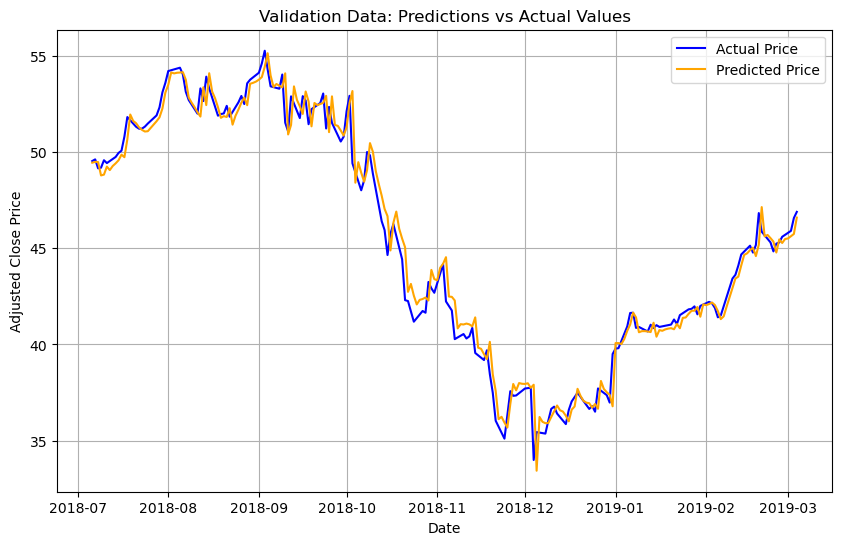

In [28]:
# Plot 2: Validation Data: Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(val_index, y_val_rescaled, label='Actual Price', color='blue')
plt.plot(val_index, predictions_val_rescaled, label='Predicted Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Validation Data: Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

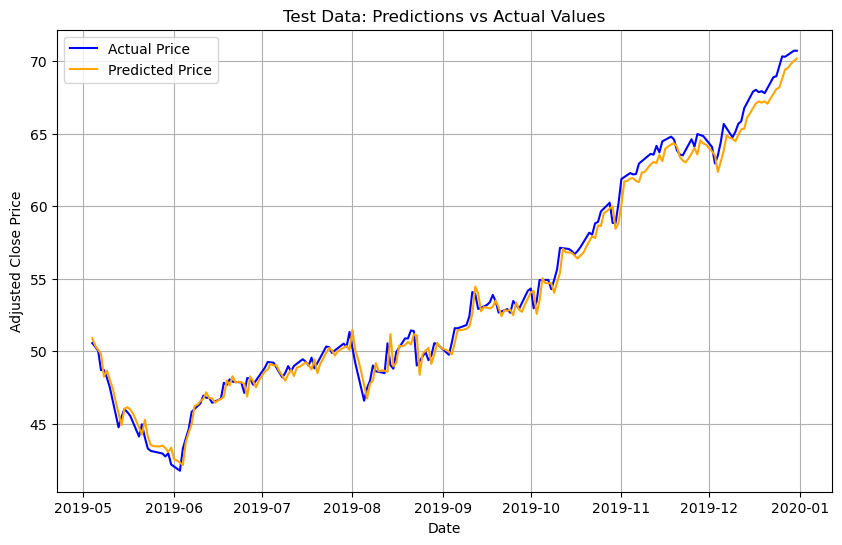

In [29]:
# Ensure that test_index has the same length as y_test_rescaled and predictions_rescaled
test_index = aapl_data.index[-len(y_test_rescaled):]  # Take the last N dates corresponding to test size

# Plot 3: Test Data: Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(test_index, y_test_rescaled, label='Actual Price', color='blue')
plt.plot(test_index, predictions_rescaled, label='Predicted Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Test Data: Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()


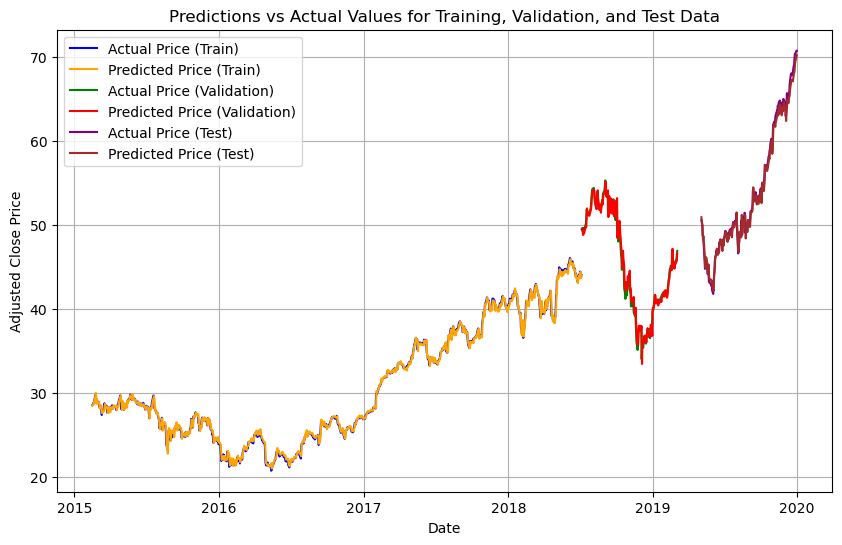

In [30]:
# Plot 4: Combined - Predictions vs Actual Values for Training, Validation, and Test Data
plt.figure(figsize=(10, 6))
plt.plot(train_index, y_train_rescaled, label='Actual Price (Train)', color='blue')
plt.plot(train_index, predictions_train_rescaled, label='Predicted Price (Train)', color='orange')
plt.plot(val_index, y_val_rescaled, label='Actual Price (Validation)', color='green')
plt.plot(val_index, predictions_val_rescaled, label='Predicted Price (Validation)', color='red')
plt.plot(test_index, y_test_rescaled, label='Actual Price (Test)', color='purple')
plt.plot(test_index, predictions_rescaled, label='Predicted Price (Test)', color='brown')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Predictions vs Actual Values for Training, Validation, and Test Data')
plt.legend()
plt.grid(True)
plt.show()
